<b>Problem</b>: The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption.

<b>Dataset</b>: Same as Notebook -- 1. Load and Explore Household Energy Usage Data

<b>Models</b>: 
1. RNN with univariate and multivariate input data

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [2]:
# Load all data
dataset = pd.read_csv(
    filepath_or_buffer='Data/household_power_consumption.txt',
    sep=';', header=0,low_memory=False, na_values='?',
    parse_dates={'datetime':[0,1]}, index_col=['datetime'],
    dtype={
        'Global_active_power' : np.float64,
        'Global_reactive_power' : np.float64,
        'Voltage' : np.float64,
        'Global_intensity' : np.float64,
        'Sub_metering_1' : np.float64,
        'Sub_metering_2' : np.float64,
        'Sub_metering_3' : np.float64
    }
)
print(dataset.shape)
print(dataset.head())

(2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

In [3]:
# Fill missing values with a value at the same time previous day or any other day
def fill_missing(values, days_ago):
    period = int(days_ago) * 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - period, col]
# fill missing
fill_missing(values=dataset.values, days_ago=1)                
dataset.loc[np.isnan(dataset.Sub_metering_1)]
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [4]:
# example of resmapling and aggregation
daily_groups = dataset.resample('D').sum()
daily_groups

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-12-07,1109.574,285.912,345914.85,4892.0,1724.0,646.0,6444.0
2010-12-08,529.698,169.098,346744.70,2338.2,0.0,514.0,3982.0
2010-12-09,1612.092,201.358,347932.40,6848.2,1805.0,2080.0,8891.0


### Univariate LSTMs 
###### 1. Vanilla 
###### 2. Encoder-Decoder

In [5]:
# Train and Test Sets
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-329], data[-329:-7]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train) / 7))
    test = np.array(np.split(test, len(test) / 7))
    return train, test

In [6]:
# split into train and test
train, test = split_dataset(daily_groups.values)
print(type(train))
print(len(train))
print(train.shape)
print(len(test))
print(test.shape)

<class 'numpy.ndarray'>
161
(161, 7, 7)
46
(46, 7, 7)


In [7]:
# Shape of train:
# (161, 7, 7)
# convert history into inputs and outputs
# Example: 
#    Input                                      Output
# [d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
# [d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]

def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [14]:
print("Input shape")
print(train.shape)
print("Various output shapes")
datareshape_test_1, y_test = to_supervised(train, n_input=7, n_out=7)
print(datareshape_test_1.shape, y_test.shape)
datareshape_test_2, y_test = to_supervised(train, n_input=7, n_out=14)
print(datareshape_test_2.shape, y_test.shape)
datareshape_test_3, y_test = to_supervised(train, n_input=8, n_out=7)
print(datareshape_test_3.shape, y_test.shape)
datareshape_test_4, y_test = to_supervised(train, n_input=8, n_out=14)
print(datareshape_test_4.shape, y_test.shape)

Input shape
(161, 7, 7)
Various output shapes
(1114, 7, 1) (1114, 7)
(1107, 7, 1) (1107, 14)
(1113, 8, 1) (1113, 7)
(1106, 8, 1) (1106, 14)


In [16]:
# train the model
def build_model(train, n_input, verbose=False, epochs=70, batch_size=16):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(layer=LSTM(
        units=200, activation='relu',
        input_shape=(n_timesteps, n_features)
    ))
    model.add(layer=Dense(units=100, activation='relu'))
    model.add(layer=Dense(units=n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(
        x=train_x, y=train_y, epochs=epochs,
        batch_size=batch_size, verbose=verbose
    )
    return model

In [17]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    mse_all = mean_squared_error(actual, predicted)
    score = np.sqrt(mse_all)
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [18]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [20]:
# evaluate a single model
def evaluate_model(train, test, n_input, epochs=20):
    # fit model
    model = build_model(train, n_input, epochs=epochs)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

cnn: [574.316] 551.8, 605.9, 497.8, 603.2, 507.8, 595.7, 642.6


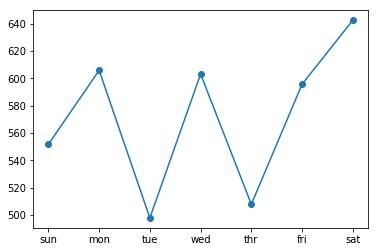

In [24]:
# split into train and test
train, test = split_dataset(daily_groups.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input, epochs=70)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='cnn')
plt.show()

cnn: [584.891] 566.7, 645.6, 526.2, 592.6, 503.8, 618.2, 626.7


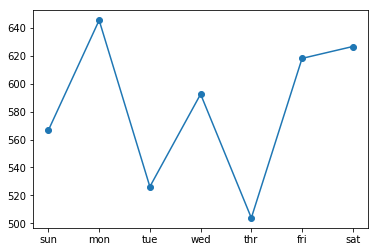

In [26]:
# split into train and test
train, test = split_dataset(daily_groups.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input, epochs=100)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='cnn')
plt.show()